# Anomaly Detection of Wikipedia Visits for R page

The aim of this study to learn anomaly detection in time series using Facebook Prophet. I am following the works of Michael Duan and Cathy Xu published in this [blog](https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473). The authors worked on seismic data but unfortunately didn't shaered their data online. Thus, I searched for [benchmark datasets for time series anomaly detection](https://www.researchgate.net/post/What_are_anomaly_detection_benchmark_datasets). I decided to use *Yahoo - a benchmark dataset for TSAD* which is a dataset released by Yahoo Labs to detect unusual traffic on Yahoo servers but accessing to that dataset needs Yahoo's approval. I made my request and in the time being I will work on the logged Wikipedia visits to the R page which can be accessed from [here](https://github.com/facebook/prophet/tree/master/examples). 


## Explaratory Data Analysis

The dataset composed of two columns one for date (ds), and one for page visits (y). There are 2863 samples in the set.

In [1]:
import pandas as pd
df = pd.read_csv('../input/example_wp_log_R_outliers1.csv')
df.head()

,ds,y
0,2008-01-30,5.976351
1,2008-01-16,6.049733
2,2008-01-17,6.011267
3,2008-01-14,5.953243
4,2008-01-15,5.910797


In [2]:
df.shape

(2863, 2)

The data is collected in between 2008 and 2015 for 8 years.

In [3]:
print(df.ds.min())
print(df.ds.max())

2008-01-01
2015-12-31


There are no missing values.

In [4]:
df.isna().sum()

ds    0
y     0
dtype: int64

In the original version of the dataframe date column is stored as object and has to be converted to datetime.

In [5]:
df.dtypes

ds     object
y     float64
dtype: object

In [6]:
df.ds = pd.to_datetime(df.ds, yearfirst=True, format= '%Y-%m-%d')
#print(df.head())

df = df.set_index("ds")
#df_vis.index = pd.to_datetime(df_vis.index)

print(df.head())

                   y
ds                  
2008-01-30  5.976351
2008-01-16  6.049733
2008-01-17  6.011267
2008-01-14  5.953243
2008-01-15  5.910797


Wikipedia hits for R page, seems to get saturated after a while. Logistic growth model of Prophet might be used.

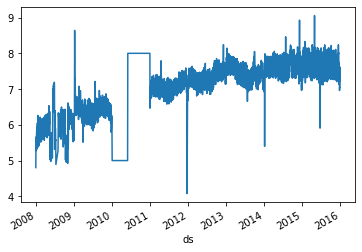

In [7]:
import matplotlib.pyplot as plt
df.y.plot()
plt.show()

For plotting purposes, index of the dataframe was set equal to ds. This resulted in loosing ds column but Prophet needs ds and y columns. Now, we have to change the columns back to normal.

In [8]:
df.columns

Index(['y'], dtype='object')

In [9]:
df = pd.read_csv('../input/example_wp_log_R_outliers1.csv')
df.ds = pd.to_datetime(df.ds, yearfirst=True, format= '%Y-%m-%d')
print(df.dtypes)
df.head()

ds    datetime64[ns]
y            float64
dtype: object


,ds,y
0,2008-01-30,5.976351
1,2008-01-16,6.049733
2,2008-01-17,6.011267
3,2008-01-14,5.953243
4,2008-01-15,5.910797


### Peculiar Case of Constant Visits in 2010

Interestingly, in between Jan. 1st, 2010 and Jan. 1st, 2011 the plot seems awkward. In the first half of the year Wikipedia page gets a constant hit of 5 visits per day and in the second half of the year this number is increased to 8.

(353, 2)


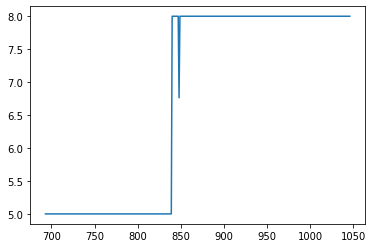

In [10]:
from datetime import datetime
df_gap = df[df.ds > datetime(2010, 1, 1)]
df_gap = df_gap[df_gap.ds < datetime(2011, 1, 1)]
print(df_gap.shape)
df_gap.y.plot()

A quick glance at the descriptive statistics of the dataset tells us that median is larger than the mean. Thus, the distribution of the page visits are negatively skewed.

In [13]:
df.describe()

,y
count,2863.000000
mean,7.106230
std,0.845066
min,4.077537
25%,6.629363
50%,7.325149
75%,7.789247
max,9.057539


## Check for Stationarity

### Histogram

By plotting the page hit distribution of time series we obtained the plot below. Upon visual inspection, it is appearent that the distribution is not normal, highly skewed to the left.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001881D130948>]],
      dtype=object)

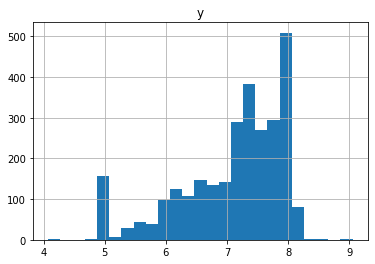

In [14]:
df.hist(bins=25)

### QQ Plot

Another way of checking stationarity is According to the QQ plot below, the scatter plot of points in a diagonal line does not fit the expected diagonal pattern for a sample from a Gaussian distribution. So our distribution is not normal, hence our time series data is non-stationary.

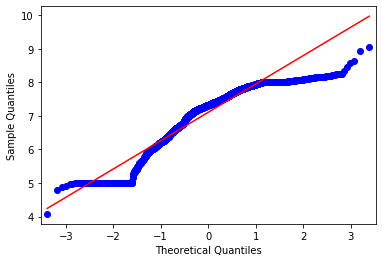

In [15]:
# QQ Plot
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# q-q plot
qqplot(df.y, line='s')
pyplot.show()

### Global vs. Local Test

We can also proved non-stationarity by splitting the time series into two contiguous sequences. Then we calculate the mean and variance of each group of numbers and compare the values. The parameters of those two groups are very different from eachother, so we conclude that we are dealing with a non-stationary time series data.

In [16]:
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=6.601593, mean2=7.611219
variance1=0.807719, variance2=0.110141


Due to non-stationary nature of the data we cannot use any autoregressive model in our analysis, so an additive model like Facebook's Prophet would be more appropriate.

## Check for Seasonality

### Seasonal Decomposition

According to the lecture notes of Andrius Buteikis on [Time series with trend and seasonality
components](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf), time series can be decompoesed in two ways:
+ **Additive Form:** used when magnitidute of the seasonal fluctuation does not vary with the level of the series
+ **Multiplicative Form:** used when the seasonal fluctuations increases/decreases with the trend as it is shown in [Facebook's Prophet Documentation](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html).

Since there is no appearent seasonality rising with the increasing trend in our data, we decided to go with the additive model.

We first tried to use Pandas' *infer_freq* method could not infer the frequency of the time series, the frequency cannot be inferred automatically.

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model="multiplicative")
result.plot()
pyplot.show()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [11]:
print(pd.infer_freq(df.ds, warn=True))

None


Since frequency cannot be inferred, seasonal decomposition cannot be made without explicityly defining the period. Upon experimenting with period we observed no weekly seasonaliy.

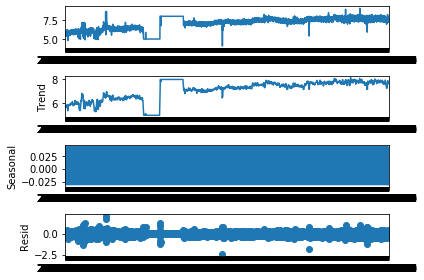

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='additive', period=7)
result.plot()
pyplot.show()

When the period set to length of a month, fluctuations start to appear.

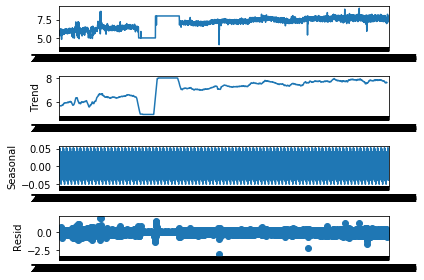

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='additive', period=30)
result.plot()
pyplot.show()

When period set to a length of a quarter:

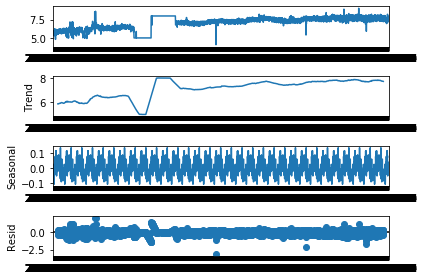

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='additive', period=round(365.25/4))
result.plot()
pyplot.show()

When period set to a length of a year:

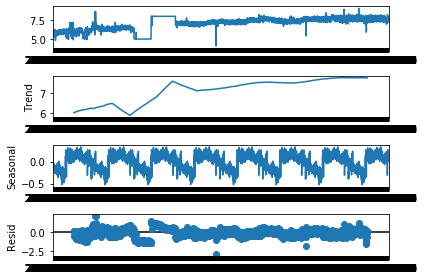

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.read_csv('../input/example_wp_log_R_outliers1.csv', header=0, index_col=0)
result = seasonal_decompose(series, model='additive', period=round(365.25))
result.plot()
pyplot.show()

In [49]:
from statsmodels.tsa.seasonal import STL
stl = STL(series)
res = stl.fit()
fig = res.plot()

ValueError: Unable to determine period from endog

### Autocorrelation Plot

According to the [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc443.htm#:~:text=If%20there%20is%20significant%20seasonality,the%20further%20out%20we%20go)., "If there is significant seasonality, the autocorrelation plot should show spikes at lags equal to the period. For example, for monthly data, if there is a seasonality effect, we would expect to see significant peaks at lag 12, 24, 36, and so on (although the intensity may decrease the further out we go)." The same discussion approved by Rob J Hyndman and George Athanasopoulos in [Forecasting: Principles and Practice](https://otexts.com/fpp3/acf.html), too. Since there is no oscillation appearent in ACF we conclude that there is no seasonality present in the data.

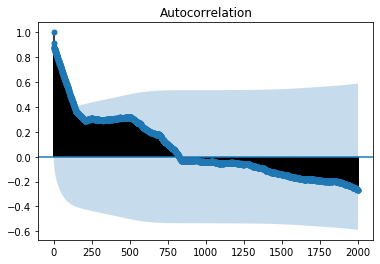

In [47]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series, lags = 2000)
pyplot.show()

## Modelling

### Linear Model without Seasonality

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


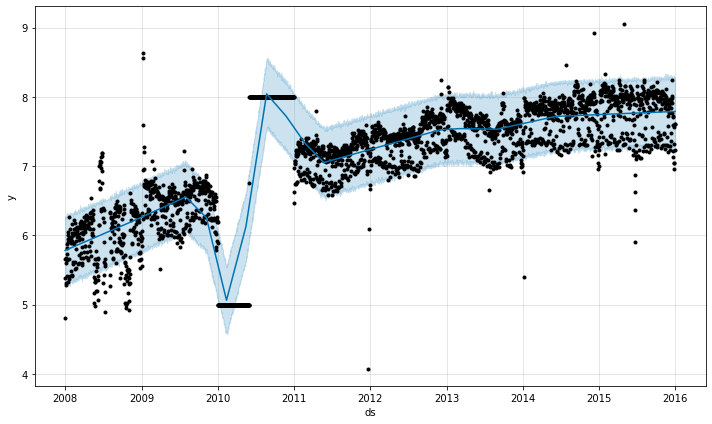

In [52]:
from fbprophet import Prophet
#Build the Model
linear = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='linear',interval_width=0.8)
#linear.add_regressor('weekend')
# Prediction without Seasonality
linear = linear.fit(df)
forecast = linear.predict(df)
forecast['fact'] = df['y'].reset_index(drop = True)
fig1 = linear.plot(forecast)

In [ ]:
#### Prediction without Seasonality


### Linear Model with Seasonality
The authors were working with a linear model with daily seasonality only, because their data was seismic. Since I am crunching web traffic data I donot expect to see daily seasonality but weeekly may be. So I build my first linear model with yearly and weekly with seasonalities. I kept using *weekends* as a exogenous regressor as Duan and Zu did. I did not make use of *US Hollidays* since Wikipedia can be accessed from any place in the Earth. 
While adding seasonalities, I followed [van der Merwe](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3)'s suggestions and added the seperately. The advantange in doing so is to be able to define uncertainty for each seasonality, later.

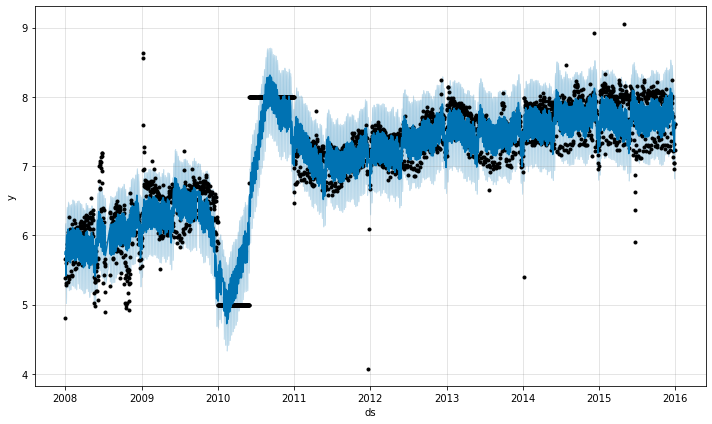

In [56]:
from fbprophet import Prophet
seasonal = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False, growth='linear',interval_width=0.8)
seasonal.add_seasonality(name = "weekly",period = 7, fourier_order=20)
seasonal.add_seasonality(name = "yearly",period = 365.25, fourier_order=15)
#m.add_country_holidays(country_name='US')
#seasonal.add_regressor('weekend')
seasonal = seasonal.fit(df)
seasonal_forecast = seasonal.predict(df)
seasonal_forecast['fact'] = df['y'].reset_index(drop = True)
fig2 = seasonal.plot(seasonal_forecast)

## Detecting Anomalies

The light blue boundaries are yhat_upper and yhat_lower defines the prediction interval. The points outside this interval is considered as outliers. The relative distance of an anomaly point to the closest boundary defines the importance of that specific point.

### Without seasonality:

In [58]:
forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
forecasted['anomaly'] = 0
forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
forecasted['importance'] = 0
forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
(forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
(forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

forecasted.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2008-01-01,5.783290,5.783290,5.288932,6.273731,5.976351,0,0.0
1,2008-01-02,5.784589,5.784589,5.277699,6.276388,6.049733,0,0.0
2,2008-01-03,5.785887,5.785887,5.326566,6.240835,6.011267,0,0.0
3,2008-01-04,5.787186,5.787186,5.306692,6.271930,5.953243,0,0.0
4,2008-01-05,5.788484,5.788484,5.299114,6.267801,5.910797,0,0.0


### With Seasonality:

In [59]:
seasonal_forecasted = seasonal_forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
seasonal_forecasted['anomaly'] = 0
seasonal_forecasted.loc[seasonal_forecasted['fact'] > seasonal_forecasted['yhat_upper'], 'anomaly'] = 1
seasonal_forecasted.loc[seasonal_forecasted['fact'] < seasonal_forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
seasonal_forecasted['importance'] = 0
seasonal_forecasted.loc[seasonal_forecasted['anomaly'] ==1, 'importance'] = \
(seasonal_forecasted['fact'] - seasonal_forecasted['yhat_upper'])/seasonal_forecast['fact']
seasonal_forecasted.loc[seasonal_forecasted['anomaly'] ==-1, 'importance'] = \
(seasonal_forecasted['yhat_lower'] - seasonal_forecasted['fact'])/seasonal_forecast['fact']

seasonal_forecasted.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2008-01-01,5.082528,5.728926,5.331690,6.139575,5.976351,0,0.000000
1,2008-01-02,5.083554,5.761206,5.391950,6.154317,6.049733,0,0.000000
2,2008-01-03,5.084579,5.772743,5.399790,6.178622,6.011267,0,0.000000
3,2008-01-04,5.085605,5.720118,5.320321,6.102892,5.953243,0,0.000000
4,2008-01-05,5.086631,5.419017,5.022898,5.793923,5.910797,1,0.019773


## References

+ [Outlier Detection DataSets (ODDS)](http://odds.cs.stonybrook.edu/#table3)
+ [What are anomaly detection benchmark datasets?](https://www.researchgate.net/post/What_are_anomaly_detection_benchmark_datasets)
+ [Using Prophet for Anomaly Detection](https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473)
+ [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)
+ [EDA and Time Series Modeling](https://www.kaggle.com/grosvenpaul/eda-and-time-series-modeling?)
+ [Implementing Facebook Prophet efficiently](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3)
+ [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc443.htm#:~:text=If%20there%20is%20significant%20seasonality,the%20further%20out%20we%20go)
+ [Time series with trend and seasonality
components](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf)
+ [Multiplicative Seasonality](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html)
+ [Autocorrelation](https://otexts.com/fpp3/acf.html)